# Read and analysis slow control data version 2


Updated June 10th 2024

Starting with headers, envorimental varibles, and functions

In [27]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os,platform
import datetime,calendar
from scipy.optimize import fsolve

A= 3.9083*10**(-3)
B= -5.775*10**(-7)
C= -4.183*10**(-12)

omb_map_20240901=[[4,"Pressure_Nitro"],[5,"Pressure_Manifold"],[6,"Flow_Meter"],[7,"Pressure_Cryostat"]]
omb_map=omb_map_20240901

tc08_map_20240901=[[0,"Cold_Finger"],[1,"Xe_Cell_Outside"],[2,"Nitro_Reservoir"],[7,"Storage_1"],[8,"Storage_2"]]
tc08_map=tc08_map_20240901

#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_dataloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_dataloc =r"\\172.24.54.234\NAS-Lab28\Data\SlowControl"
    
elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_dataloc =r"\\172.24.54.234\NAS-Lab28\Data\SlowControl" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


TimeZero=datetime.datetime(2023,1,1)


## Functions and def

#### h5 file info

In [2]:
groups = []
datasets = []
atts = {} # attributes

def gather_names_and_atts(name, obj):
    if isinstance(obj, h5py.Group):
        groups.append(name)
    elif isinstance(obj, h5py.Dataset):
        datasets.append(name)
    for key, val in obj.attrs.items():
        atts[name + '/' + key] = val

def list_groups_datasets_atts(file):
    with h5py.File(file, 'r') as f:
        f.visititems(gather_names_and_atts)

def print_lists(list_name):
    i = 0
    for name in list_name:
        print(i, name)
        i=i+1
    print()

def create_dataframe_from_datasets(file_name, dataset_names):

    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
       
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
       
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }
    return dfs


def poop():
    with h5py.File(file_name, 'r') as f:
        for name in dataset_names:
            try:
                dfs = {name: pd.DataFrame(f[name][:]) }
            except:
                print("issue with", name)
    return dfs

In [3]:

# Define the equation to solve
def RTD_equ(T, r, A,B,C):
    R = 100   # The value of R
    # A = 3.9083*10**(-3)   # The value of A
    # B = -5.775*10**(-7) # The value of B
    # C = -4.183*10**(-12) # The value of C
    return R * (A * T + B * T**2 + C * T**3 * (100 - T)) - r

def RTD_voltage_Calibration(voltage,A= 3.9083*10**(-3),B= -5.775*10**(-7),C= -4.183*10**(-12)):
    current=0.0002 #amps
    r = voltage/current

    # Initial guess for T
    T_guess = 500

    # Solve for T
    return fsolve(RTD_equ, T_guess, args=(r, A,B,C))
    

def RTD_root_calibration(Vs,RTD_const):
    Ts=[]
    for v in Vs:
        coef=[RTD_const[0][3]/10,RTD_const[0][2]/100,RTD_const[0][1]/10,RTD_const[0][0],v-100]
        if r <=0.0200039:
            Ts.append(np.roots(coef)[3].real+273.15)
        else:
            Ts.append(np.roots(coef[2:])[1].real+273.15)
    return Ts


In [4]:
def det_map(date):
    global omb_map
    global TC08_map

    omb_map=omb_map_20240901
    
    

def add_hour(DF):

    times=DF["Time"]
    hours=[]
    for t in times:
        dts = TimeZero + datetime.timedelta(seconds=t)
        hours.append(dts.hour + dts.minute/60 + dts.second/3600 )


    DF["hours"] = hours
    return DF

## Read in file and make dataframe function

In [42]:
channel_list_old=  ["Flow_Meter" ,"Liquid_Nitro_Valve", "PID_Heater","Pressure_1","Pressure_2",
                "Heater_State","Nitro_Baseline","Nitro_Weigth","Target_Channel","Target_Temperature",
                "Time","Valve_State","Cold_Finger","Nitro_Reservoir","Xe_Cell_1","Xe_Cell_2",
                "Xe_Cell_3","Xe_Cell_Outside","Pressure_Cell","Pressure_Mfold","Storage_1","Storage_2",
                "Pressure_Cryostat","Pressure_Manifold","Pressure_Nitro","Cryostat_Top","Xe_Cell_Bottom","Xe_Cell_Top"]

channel_list=  ["Flow_Meter" ,"Liquid_Nitro_Valve", "PID_Heater","Pressure_1","Pressure_2",
                "Heater_State","Nitro_Baseline","Nitro_Weigth","Target_Channel","Target_Temperature",
                "Time","Valve_State","Cold_Finger","Nitro_Reservoir","Xe_Cell_1","Xe_Cell_2",
                "Xe_Cell_3","Xe_Cell_Outside","Pressure_Cell","Pressure_Mfold","Storage_1","Storage_2",
                "Pressure_Cryostat","Pressure_Manifold","Pressure_Nitro","RTD_1","RTD_2","RTD_3","RTD_4"]





def getprologue_time(f):
    ''' Argument f == hdf5 file
        returns datetimeobject of time information 
    '''
    atr="Prologue"
    prologue=f.attrs[atr]
    prologue=prologue.replace("\r","")
    splitlog=prologue.split( "\n")
    timeinfostr=splitlog[2]
    timeinfo={}
    timeinfo["year"]=int(timeinfostr[0:4])
    timeinfo["mon"]=int(timeinfostr[4:6])
    timeinfo["day"]=int(timeinfostr[6:8])
    timeinfo["hour"]=int(timeinfostr[8:10])
    timeinfo["min"]=int(timeinfostr[10:12])
    timeinfo["sec"]=int(timeinfostr[12:14])
    
    strtime=""
    for key in timeinfo.keys():
        strtime=strtime+"%s"%(str(timeinfo[key]))
    RunStart_Datetime=datetime.datetime.strptime(strtime, "%Y%m%d%H%M%S") #takes a string in the listed format and turns it into a datetime object
    print(timeinfo)

    print(timeinfo, RunStart_Datetime)
    return RunStart_Datetime 

def timetosecs(timeinfo):
    '''argument timeinfo dict returns total seconds for the day
    Need to make this return time from some time in the past to allow for overnight runs'''


    return timeinfo["hour"]*60*60 +timeinfo["min"]*60+timeinfo["sec"]



def calib_dict_wtime(file_name):
    ''' This function grabs the slow control data from the hdf5 file that offsets the time by amount of seconds since Jan 1 2020'''
    fh5= h5py.File(file_name, 'r') 
    timeinfo=getprologue_time(fh5)
    timeoffset=(timeinfo-TimeZero).total_seconds()
    print("Time offset",timeoffset)
    fh5.close()
    list_groups_datasets_atts(file_name)
    dataset_names = datasets # to create a dataframe for each
    datadict = create_dataframe_from_datasets(file_name, dataset_names)
    newdict={}
    l,m,n=-1,-1,-1
    j=0
    js=[-1,-1,-1]
    print(datadict.keys())
    for key in datadict.keys():

        #print(key)
        pos=key.find("/")
        group=key[:pos]
        if group=="omb_daq":
            j=0
            l+=1
            js[0]+=1
        elif group=="pid_info":
            j=1
            m+=1
            js[1]+=1
        elif group=="tc08_daq":
            j=2
            n+=1
            js[2]+=1
        
        m,b=1,0
        s_key=key[pos+1:]

        if s_key =="Pressure_1":
            s_key="Pressure_Cell"
        elif s_key =="Pressure_2":
            s_key="Pressure_Manifold"
        if s_key not in channel_list:
            
           print("Not in channel list " ,s_key)
           # continue

        if s_key=="Inter" or s_key =="Slope":
                continue
        
        else:
            
            if "RTD" in s_key:
                newdict[s_key]=datadict[key][0]
                continue
            
            #print(group,key, js[j])
            if j==1:
                m,b=1,0
            else:
                try:
                    m = datadict["%s/Slope"%(group)][0][js[j]]
                    b = datadict["%s/Inter"%(group)][0][js[j]]
                except:
                    m,b=1,0
        
            
        #print(m,b, )
        
        newdict[s_key]=datadict[key][0]*m +b
    
    try:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict["Time"])*2,2)
    except:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict[s_key])*2,2)
    
    return newdict



def get_slow_ctr_df(filedate):

    filedes ="slow_control"
    datadir="./data"
    
    try:
        filedate=str(filedate)
    except:
        print("Issue with file date")

    filelist=glob.glob("%s/%s*.h5"%(datadir,filedate))
    print(filelist)
    if len(filelist) <1:
        print("Error with globing files")

    datadicts=[]
    DFs=[]
    for filename in filelist:
      
        finfo=os.stat(filename)
        print(finfo.st_size)
        if finfo.st_size < 18000:
            print("Skipping %s due to size"%(filename))
            continue
        datasets = []
        print(filename)
        datadict=calib_dict_wtime(filename)
        datadicts.append(datadict)
        try:
            DFs.append(pd.DataFrame.from_dict(datadict))
        except:
            print("issue with appending files into list")
        print( "len",len(datadict["Time"]))

    DF = pd.concat(DFs)
    DF =DF.sort_values(by=["Time"])

    return DF



def raw_dict_wtime(file_name):
    ''' This function grabs the slow control data from the hdf5 file that offsets the time by amount of seconds since Jan 1 2020'''
    fh5= h5py.File(file_name, 'r') 
    timeinfo=getprologue_time(fh5)
    timeoffset=(timeinfo-TimeZero).total_seconds()
    print("Time offset",timeoffset)
    fh5.close()
    list_groups_datasets_atts(file_name)
    dataset_names = datasets # to create a dataframe for each
    datadict = create_dataframe_from_datasets(file_name, dataset_names)
    newdict={}
    l,m,n=-1,-1,-1
    j=0
    js=[-1,-1,-1]
    print(datadict.keys())
    for key in datadict.keys():

        #print(key)
        pos=key.find("/")
        group=key[:pos]
        if group=="omb_daq":
            j=0
            l+=1
            js[0]+=1
        elif group=="pid_info":
            j=1
            m+=1
            js[1]+=1
        elif group=="tc08_daq":
            j=2
            n+=1
            js[2]+=1
        
        m,b=1,0
        s_key=key[pos+1:]

        if s_key =="Pressure_1":
            s_key="Pressure_Cell"
        elif s_key =="Pressure_2":
            s_key="Pressure_Manifold"
        if s_key not in channel_list:
            
           print("Not in channel list " ,s_key)
           # continue

        if s_key=="Inter" or s_key =="Slope":
            n_key=group+"_"+s_key
        else:
            n_key=s_key
        #        continue
        
        newdict[n_key]=datadict[key][0]

        #End of loop over keys
    
    try:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict["Time"])*2,2)
    except:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict[n_key])*2,2)


    RTDfile=h5py.File(file_name)
    RTDconstants=RTDfile["omb_daq/RTD constant"][0:4]
    RTDfile.close()
    RTDconstants = RTDconstants.flatten()
    RTD_const_full =  np.pad(RTDconstants, (0,len(newdict["Time"])-16))
    newdict["RTD constant"] = RTD_const_full.tolist()
    return newdict



def get_slow_ctr_df(filedate):

    filedes ="slow_control"
    datadir="./data"
    
    try:
        filedate=str(filedate)
    except:
        print("Issue with file date")

    filelist=glob.glob("%s/%s*.h5"%(datadir,filedate))
    print(filelist)
    if len(filelist) <1:
        print("Error with globing files")

    datadicts=[]
    DFs=[]
    for filename in filelist:
      
        finfo=os.stat(filename)
        print(finfo.st_size)
        if finfo.st_size < 18000:
            print("Skipping %s due to size"%(filename))
            continue
        datasets = []
        print(filename)
        datadict=calib_dict_wtime(filename)
        datadicts.append(datadict)
        try:
            DFs.append(pd.DataFrame.from_dict(datadict))
        except:
            print("issue with appending files into list")
        print( "len",len(datadict["Time"]))

    DF = pd.concat(DFs)
    DF =DF.sort_values(by=["Time"])

    return DF




def fixtimeoffset(DFs): 
    '''This function will take a list of '''




In [10]:
DF=pd.DataFrame.from_dict(raw_dict_wtime("A:/DATA\\20240920_slow_control_13.h5"))
DF=add_hour(DF)

{'year': 2024, 'mon': 9, 'day': 20, 'hour': 9, 'min': 39, 'sec': 10} 2024-09-20 09:39:10
Time offset 54293950.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3', 'omb_daq/RTD_4', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/RTD constant', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Outside'])
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope


In [6]:
DF=pd.DataFrame.from_dict(raw_dict_wtime(r"\\172.24.54.234\NAS-Lab28\Data\SlowControl\20250204_slow_control_1.h5"))
DF=add_hour(DF)

{'year': 2025, 'mon': 2, 'day': 4, 'hour': 8, 'min': 1, 'sec': 20} 2025-02-04 08:12:00
Time offset 66125520.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3', 'omb_daq/RTD_4', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/RTD constant', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Outside'])
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope


In [7]:
plt.DF

,Flow_Meter,omb_daq_Inter,Liquid_Nitro_Valve,PID_Heater,Pressure_Cryostat,Pressure_Manifold,Pressure_Nitro,RTD constant,RTD_1,RTD_2,...,Time,Valve_State,Cold_Finger,tc08_daq_Inter,Nitro_Reservoir,tc08_daq_Slope,Storage_1,Storage_2,Xe_Cell_Outside,hours
0,-0.002012,0.0,0.0,0.0,1.414811,0.028933,0.103257,-3.908300e-01,0.016158,0.016185,...,66125520.0,0.0,230.639343,2.630,219.785873,0.993,295.419434,295.116028,232.922150,8.200000
1,-0.001767,0.0,0.0,0.0,1.414872,0.028921,0.103281,5.775000e-05,0.016158,0.016184,...,66125522.0,0.0,230.630463,1.911,219.781204,0.995,295.424194,295.113434,232.926285,8.200556
2,-0.002013,0.0,0.0,0.0,1.414956,0.028917,0.103262,4.183000e-09,0.016158,0.016185,...,66125524.0,1.0,230.639130,2.566,219.772278,0.993,295.416840,295.110992,232.930618,8.201111
3,-0.001867,0.0,0.0,0.0,1.414967,0.028930,0.074316,-4.183000e-10,0.016160,0.016185,...,66125526.0,1.0,230.630676,2.594,188.754517,0.992,295.419434,295.108704,232.926483,8.201667
4,-0.001909,-0.7,0.0,0.0,1.415055,0.028943,0.070120,-3.908300e-01,0.016160,0.016185,...,66125528.0,1.0,230.630676,2.346,206.896576,0.993,295.421875,295.116028,232.930817,8.202222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22081,-0.001590,NaN,0.0,0.0,-0.002964,0.029071,0.095556,0.000000e+00,0.019925,0.018404,...,66169682.0,0.0,283.539459,NaN,247.234161,NaN,159.413315,294.645996,292.039459,20.467222
22082,-0.001831,NaN,0.0,0.0,-0.002861,0.029074,0.102747,0.000000e+00,0.019928,0.018406,...,66169684.0,0.0,283.561859,NaN,247.258728,NaN,159.423813,294.648438,292.065613,20.467778
22083,-0.001335,NaN,0.0,0.0,-0.002946,0.028572,0.101972,0.000000e+00,0.019929,0.018406,...,66169686.0,0.0,283.576782,NaN,247.283295,NaN,159.430801,294.645996,292.084290,20.468333
22084,-0.001737,NaN,0.0,0.0,-0.002793,0.027182,0.097099,0.000000e+00,0.019930,0.018408,...,66169688.0,0.0,283.599060,NaN,247.311768,NaN,159.434082,294.650726,292.106537,20.468889


In [11]:
def GetAllFiles(date):
    if type(date)==type("str") or type(date) == type(2):
        date_placeholder=date
        date=[]
        date.append(date_placeholder)
    elif type(date) != type(["str","str"]):
        print("Issue with argument - date \n Please use string or list of strings in the format YYYYMMDD")
        return [""]
    file_list=[]
    for d in date:
        search_term=env_var_dataloc+str(d)+"*"
        file_list=file_list+glob.glob(search_term)
    return file_list


def Get_SlowControl_DF_fromlist(filelist):
    if type(filelist)==type("str"):
        filelist_placeholder=filelist
        filelist=[]
        filelist.append(date_placeholder)
    elif type(file_list) != type(["str","str"]):
        print("Issue with argument - date \n Please use string with the filepath")
        return [""]
    slowcontrol_dict_list=[]
    for file in file_list:
        if os.path.getsize(file) <=30000:
            continue
        slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
        DF=pd.concat(slowcontrol_dict_list)
    return DF

def Get_SlowControl_DF(date):
    DF=pd.DataFrame()
    if type(date)==type("str") or type(date) == type(2):
        date_placeholder=date
        date=[]
        date.append(date_placeholder)
    elif type(date) != type(["str","str"]):
        print("Issue with argument - date \n Please use string or list of strings in the format YYYYMMDD")
        return DF
    file_list=GetAllFiles(date)
    slowcontrol_dict_list=[]
    for file in file_list:
        if os.path.getsize(file) <=30000:
            print("Skipping %s"%(file))
            continue
        slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
        DF=pd.concat(slowcontrol_dict_list)
    return DF


In [12]:
filedate="20240920"
filedes ="slow_control"
datadir =env_var_dataloc

filelist=glob.glob("%s%s*.h5"%(datadir,filedate))
print(filelist)

['A:/DATA\\20240920_slow_control.h5', 'A:/DATA\\20240920_slow_control_1.h5', 'A:/DATA\\20240920_slow_control_10.h5', 'A:/DATA\\20240920_slow_control_11.h5', 'A:/DATA\\20240920_slow_control_12.h5', 'A:/DATA\\20240920_slow_control_13.h5', 'A:/DATA\\20240920_slow_control_14.h5', 'A:/DATA\\20240920_slow_control_2.h5', 'A:/DATA\\20240920_slow_control_3.h5', 'A:/DATA\\20240920_slow_control_4.h5', 'A:/DATA\\20240920_slow_control_5.h5', 'A:/DATA\\20240920_slow_control_6.h5', 'A:/DATA\\20240920_slow_control_7.h5', 'A:/DATA\\20240920_slow_control_8.h5', 'A:/DATA\\20240920_slow_control_9.h5']


In [25]:
glob.glob(r"//172.24.54.234/NAS-Lab28/Data/SlowControl/*")

['//172.24.54.234/NAS-Lab28/Data/SlowControl\\20250204_slow_control.h5',
 '//172.24.54.234/NAS-Lab28/Data/SlowControl\\20250204_slow_control_1.h5',
 '//172.24.54.234/NAS-Lab28/Data/SlowControl\\20250204_slow_control_2.h5']

In [28]:
filedate="20250204"
filedes ="slow_control"
datadir =env_var_dataloc
print(datadir)

print("%s\%s*.h5"%(datadir,filedate))
filelist=glob.glob("%s/%s*.h5"%(datadir,filedate))

print(filelist)

\\172.24.54.234\NAS-Lab28\Data\SlowControl
\\172.24.54.234\NAS-Lab28\Data\SlowControl\20250204*.h5
['\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control.h5', '\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control_1.h5', '\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control_2.h5']


## Calibrate functions

In [56]:
def OMB_Calibration(raw_DF):
    ''' Takes the raw OMB DF and calibrations the flow metere and pressure sensors'''
    Keys=raw_DF.keys()
    if "omb_daq_Inter" not in Keys or "omb_daq_Slope" not in Keys:
        print("New calibration constants")
        return raw_DF
    Inter=raw_DF["omb_daq_Inter"]
    Slope=raw_DF["omb_daq_Slope"] 
    calib_DF=raw_DF.copy()
    for i,calib_key in omb_map:
        print(calib_key)    
        calib_DF[calib_key]=Inter[i]+Slope[i]*raw_DF[calib_key]
    return calib_DF




## Read slowcontrol data - from 20231110

In [14]:
filedate="20240520"
filedes ="slow_control"
datadir =env_var_dataloc

filelist=glob.glob("%s%s*.h5"%(datadir,filedate))

print(filelist)

datadicts=[]
DFs=[]
for filename in filelist:
    datasets = []
    print(filename)
    datadict=calib_dict_wtime(filename)
    datadicts.append(datadict)
    print( "len",len(datadict["Time"]))
    if len(datadict) >=4:
        DFs.append(pd.DataFrame.from_dict(datadict))
    else:
        print(len(pd.DataFrame.from_dict(datadict)), type(pd.DataFrame.from_dict(datadict)))

    







[]


In [15]:

def Get_dict_from_hdf5(file_name):
    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
        
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
        
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }

    return dfs

In [16]:
f = h5py.File(file,'r')
for i in f.keys():
    for j in f[i].keys():
        print(f[i+"/"+j][:])
        break

NameError: name 'file' is not defined

## Read slowcontrol data - from 20240606

In [ ]:
date=20240605
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
date=20240606
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =file_list + glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June06=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240605_slow_control.h5', 'A:/DATA\\20240605_slow_control_1.h5', 'A:/DATA\\20240605_slow_control_2.h5', 'A:/DATA\\20240605_slow_control_3.h5', 'A:/DATA\\20240605_slow_control_4.h5', 'A:/DATA\\20240605_slow_control_5.h5', 'A:/DATA\\20240605_slow_control_6.h5', 'A:/DATA\\20240606_slow_control.h5', 'A:/DATA\\20240606_slow_control_1.h5', 'A:/DATA\\20240606_slow_control_2.h5', 'A:/DATA\\20240606_slow_control_3.h5', 'A:/DATA\\20240606_slow_control_4.h5']
Time offset 45047858.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1'

## Read slowcontrol data - from 20231110

In [ ]:
date=20231110
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*.h5"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    print(file)
    if os.path.getsize(file) <=40000:
        print("\t\t too small")
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_Nov10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20231110_slow_control.h5', 'A:/DATA\\20231110_slow_control_1.h5', 'A:/DATA\\20231110_slow_control_10.h5', 'A:/DATA\\20231110_slow_control_11.h5', 'A:/DATA\\20231110_slow_control_12.h5', 'A:/DATA\\20231110_slow_control_13.h5', 'A:/DATA\\20231110_slow_control_14.h5', 'A:/DATA\\20231110_slow_control_15.h5', 'A:/DATA\\20231110_slow_control_16.h5', 'A:/DATA\\20231110_slow_control_17.h5', 'A:/DATA\\20231110_slow_control_18.h5', 'A:/DATA\\20231110_slow_control_19.h5', 'A:/DATA\\20231110_slow_control_2.h5', 'A:/DATA\\20231110_slow_control_20.h5', 'A:/DATA\\20231110_slow_control_21.h5', 'A:/DATA\\20231110_slow_control_3.h5', 'A:/DATA\\20231110_slow_control_4.h5', 'A:/DATA\\20231110_slow_control_5.h5', 'A:/DATA\\20231110_slow_control_6.h5', 'A:/DATA\\20231110_slow_control_7.h5', 'A:/DATA\\20231110_slow_control_8.h5', 'A:/DATA\\20231110_slow_control_9.h5']
A:/DATA\20231110_slow_control.h5
Time offset 27074719.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Val

In [ ]:


date=20240520
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_May20=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240520_slow_control.h5', 'A:/DATA\\20240520_slow_control_1.h5', 'A:/DATA\\20240520_slow_control_10.h5', 'A:/DATA\\20240520_slow_control_2.h5', 'A:/DATA\\20240520_slow_control_3.h5', 'A:/DATA\\20240520_slow_control_4.h5', 'A:/DATA\\20240520_slow_control_5.h5', 'A:/DATA\\20240520_slow_control_6.h5', 'A:/DATA\\20240520_slow_control_7.h5', 'A:/DATA\\20240520_slow_control_8.h5', 'A:/DATA\\20240520_slow_control_9.h5']
Time offset 33469
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell

In [ ]:
date=20240605
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=30000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20240605_slow_control.h5', 'A:/DATA\\20240605_slow_control_1.h5', 'A:/DATA\\20240605_slow_control_2.h5', 'A:/DATA\\20240605_slow_control_3.h5', 'A:/DATA\\20240605_slow_control_4.h5', 'A:/DATA\\20240605_slow_control_5.h5', 'A:/DATA\\20240605_slow_control_6.h5']
Time offset 45047858.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in c

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


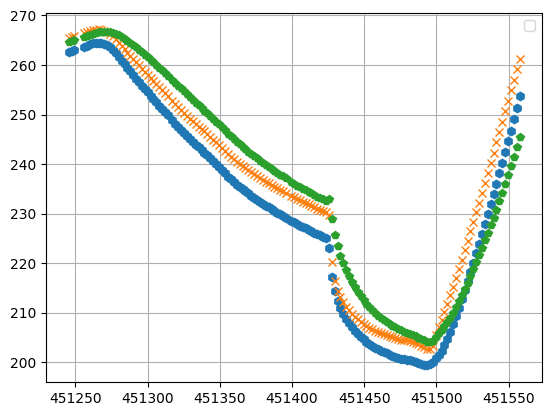

In [ ]:
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_1"][::60], fmt="h")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_2"][::60], fmt="x")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()


In [17]:
timeo=(datetime.datetime(2024,6,6)-TimeZero).total_seconds()
print(timeo)

plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Cold_Finger"][::60], fmt="h")
#plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0, y=DF_June06["Xe_Cell_Top"][::60], fmt="x")
#plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0, y=DF_June06["Cryostat_Top"][::60], fmt="p")
plt.grid()
plt.legend()

#plt.xlim(7,15)
plt.ylim(150,220)

45100800.0


NameError: name 'DF_June06' is not defined

In [18]:
timeo=(datetime.datetime(2024,6,6)-TimeZero).total_seconds()
print(timeo)


plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Flow_Meter"][::60], fmt="h", label="Bottom of drift cell")
plt.errorbar(x=(DF_June06["Time"][::60]-timeo)/3600.0  , y=DF_June06["Target_Channel"][::60])

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time [mins]")
#plt.ylabel("Temperature [K]")
plt.xlim(7,15)

45100800.0


NameError: name 'DF_June06' is not defined

In [ ]:
DF_June06.keys()

Index(['Flow_Meter', 'Liquid_Nitro_Valve', 'PID_Heater', 'Pressure_Cryostat',
       'Pressure_Manifold', 'Pressure_Nitro', 'Heater_State', 'Nitro_Baseline',
       'Nitro_Weigth', 'Target_Channel', 'Target_Temperature', 'Time',
       'Valve_State', 'Cold_Finger', 'Cryostat_Top', 'Nitro_Reservoir',
       'Storage_1', 'Storage_2', 'Xe_Cell_Bottom', 'Xe_Cell_Outside',
       'Xe_Cell_Top'],
      dtype='object')

['A:/DATA\\20240606_slow_control.h5', 'A:/DATA\\20240606_slow_control_1.h5', 'A:/DATA\\20240606_slow_control_2.h5', 'A:/DATA\\20240606_slow_control_3.h5', 'A:/DATA\\20240606_slow_control_4.h5']
Time offset 35087
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope
Time offset 61035
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inte

Text(0, 0.5, 'Pressure [pisa]')

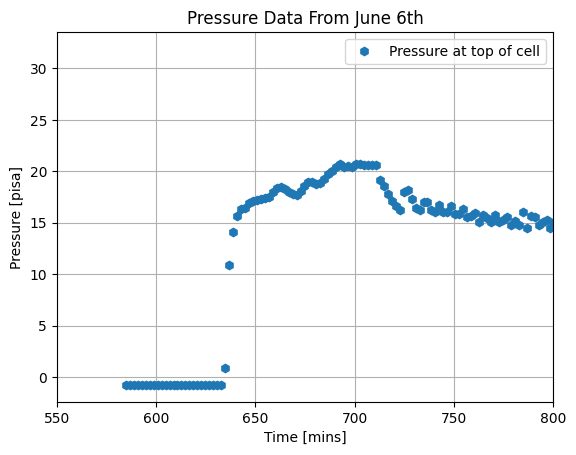

In [ ]:
date=20240606
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June06_2=pd.concat(slowcontrol_dict_list)

plt.errorbar(DF_June06_2["Time"][::60]/60.0,DF_June06_2["Pressure_Cryostat"][::60], fmt="h", label="Pressure at top of cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Pressure Data From June 6th")
plt.xlabel("Time [mins]")
plt.ylabel("Pressure [pisa]")

['A:/DATA\\20240523_slow_control_2.h5', 'A:/DATA\\20240523_slow_control_3.h5', 'A:/DATA\\20240523_slow_control_5.h5', 'A:/DATA\\20240523_slow_control_8.h5']
Time offset 37645
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope
Time offset 39437
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'om

Text(0.5, 1.0, 'Thermocouple Data on May 23rd')

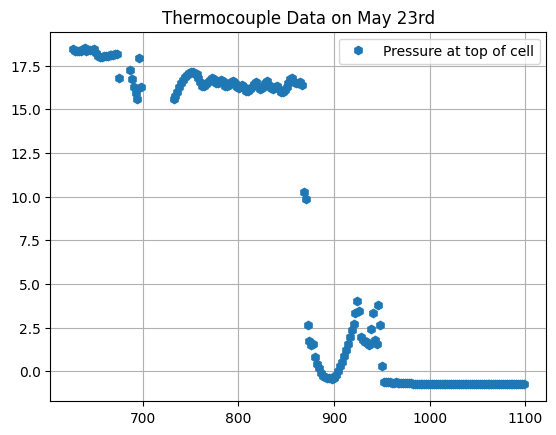

In [ ]:

date=20240523
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*_[2,3,5,8]*"
file_list = glob.glob(search_term)


print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=35000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF=pd.concat(slowcontrol_dict_list)

plt.errorbar(DF["Time"][::60]/60.0,DF["Pressure_Cryostat"][::60], fmt="h", label="Pressure at top of cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Thermocouple Data on May 23rd")

Text(0.5, 1.0, 'Thermocouple Data on May 23rd')

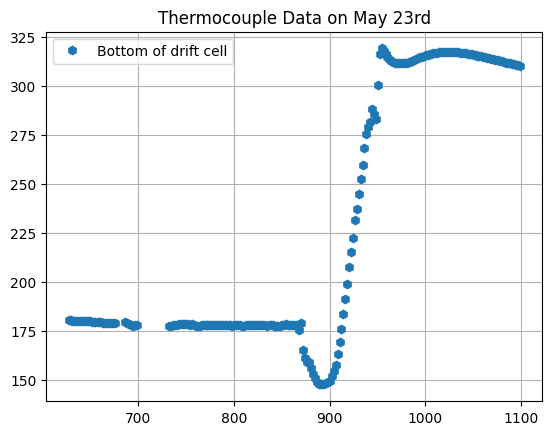

In [ ]:
plt.errorbar(DF["Time"][::60]/60.0,DF["Xe_Cell_Bottom"][::60], fmt="h", label="Bottom of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(160,220)
plt.title("Thermocouple Data on May 23rd")

In [ ]:
date=["20240202"]
type(date)

list

In [ ]:
date=20240528

print(GetAllFiles(date))
DF=Get_SlowControl_DF(date)


In [145]:
flow_threshold=0.0055


xenon_density_at_0C_1atm=(0.0058592+0.0059401)/2.0  # Density of gaseous xenon at 0C and 1 atm from a nist table  in [g/ml]- used psia of 14.6 and 14.8 to average for 14.7
xenon_flow_conversionfactor=1.32 # This is pulled from page 68 from the MKS manuel. Table of correction factors


flow_sum=0
a=[]
flow_intergration=0
flow_itergartion_list=[]
flow_running_sum=[]
flow_list=[]
for i,flow in enumerate(DF["Flow_Meter"]):
    if flow <= flow_threshold:
        flow=0     
    if i == 0 or i == len(DF["Flow_Meter"])-1:
        a.append(1)
    elif i%2 == 1:
        a.append(4)
    else:
        a.append(2)
    flow_list.append(flow)
    if flow>=5:
        print("Saturation")
    flow_intergration = (2/3) * sum(np.array(a)*np.array(flow_list))
    flow_itergartion_list.append(flow_intergration)

    flow_sum = flow*2+flow_sum
    flow_running_sum.append(flow_sum)


DF["Flow_Iter"] = flow_itergartion_list


xloc_of_mid=np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]
yval_of_mid=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][0]]
yval_of_end=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][-1]]
print(xloc_of_mid,yval_of_mid,yval_of_end)

Saturation
Saturation
Saturation
[ 5636  6701  6746 11316] 10133.816097259521 20716.33124987284


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Start of the day, since timezero 44323200.0
Start of file  44356782.0
Start of file  33582.0


Text(0.5, 0, 'Time ')

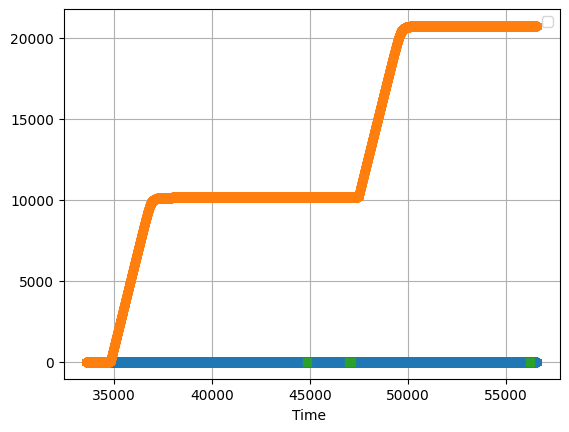

In [143]:


timeo=(datetime.datetime(2024,5,28,0,0,0)-TimeZero).total_seconds()
print("Start of the day, since timezero" ,timeo)
print("Start of file " ,DF["Time"].iloc[0])
print("Start of file ", DF["Time"].iloc[0]-timeo)


plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Meter"][::], fmt="h")

plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Iter"][::], fmt="h")
#plt.errorbar(x=(DF["Time"][::60]-timeo)/3600.0  , y=DF["Target_Channel"][::60])


x=DF["Time"][np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]] -timeo 
y=3*np.ones(len(x))
plt.errorbar(x,y,marker="s",fmt=" ")

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()
#plt.xlim(550,800)
#plt.ylim(4000,6000)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time ")

#plt.ylabel("Temperature [K]")
#plt.xlim(37500,49000)

<ErrorbarContainer object of 3 artists>

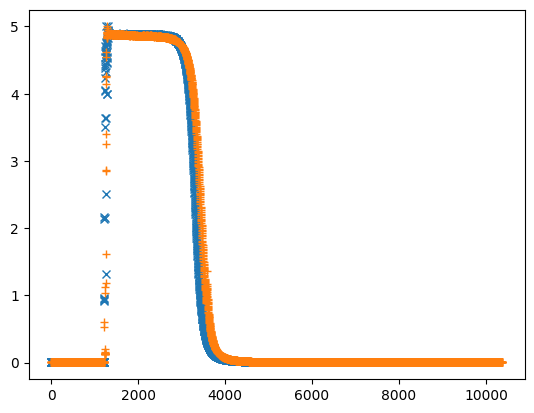

In [118]:
x1_stop=4000
x2_start=6310

x1=DF["Time"][:x1_stop]
y1=DF["Flow_Meter"][:x1_stop]

x2=DF["Time"][x2_start:]
y2=DF["Flow_Meter"][x2_start:]


plt.errorbar(x1-x1.iloc[0],y1,marker="x",fmt=" ")
plt.errorbar(x2-x2.iloc[0],y2,marker="+",fmt=" ")
#plt.xlim(1000,2000)







#### Total Flow sum for two complete pass cycles

In [60]:
# Pulls data from a double round of purification passes to attempt a flow meter itergration calibration
Calib_FlowIter_1 = 5080.177172
Calib_FlowIter_2 = 10371.57745-5080.177172

In [62]:
Calib_FlowIter_2/Calib_FlowIter_1

1.0415779014881965

In [159]:
date=20240528

print(GetAllFiles(date))
DF=Get_SlowControl_DF(date)

['A:/DATA\\20240528_slow_control.h5']
{'year': 2024, 'mon': 5, 'day': 28, 'hour': 9, 'min': 19, 'sec': 42} 2024-05-28 09:19:42
Time offset 44356782.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  Slope


In [163]:



flow_threshold=0.0055


xenon_density_at_0C_1atm=(0.0058592+0.0059401)/2.0  # Density of gaseous xenon at 0C and 1 atm from a nist table - used psia of 14.6 and 14.8 to average for 14.7
xenon_flow_conversionfactor=1.32 # This is pulled from page 68 from the MKS manuel. Table of correction factors


flow_sum=0
a=[]
flow_intergration=0
flow_itergartion_list=[]
flow_running_sum=[]
flow_list=[]
for i,flow in enumerate(DF["Flow_Meter"]):
    if flow <= flow_threshold:
        flow=0     
    if i == 0 or i == len(DF["Flow_Meter"])-1:
        a.append(1)
    elif i%2 == 1:
        a.append(4)
    else:
        a.append(2)
    flow_list.append(flow*60*xenon_density_at_0C_1atm)
    if flow>=5:
        print("Saturation")
    flow_intergration = (2/3) * sum(np.array(a)*np.array(flow_list))
    flow_itergartion_list.append(flow_intergration)

    flow_sum = flow*2+flow_sum
    flow_running_sum.append(flow_sum)


DF["Flow_Iter"] = flow_itergartion_list


xloc_of_mid=np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]
yval_of_mid=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.000005)[0][0]]
yval_of_end=DF["Flow_Iter"].loc[np.where(DF["Flow_Meter"].diff(1500) < 0.0000005)[0][-1]]

print(xloc_of_mid,yval_of_mid,yval_of_end)

Saturation
Saturation
Saturation
[ 5636  6701  6746 11316] 3587.158088291825 7333.146219498719


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Start of the day, since timezero 44323200.0
Start of file  44356782.0
Start of file  33582.0


Text(0.5, 0, 'Time ')

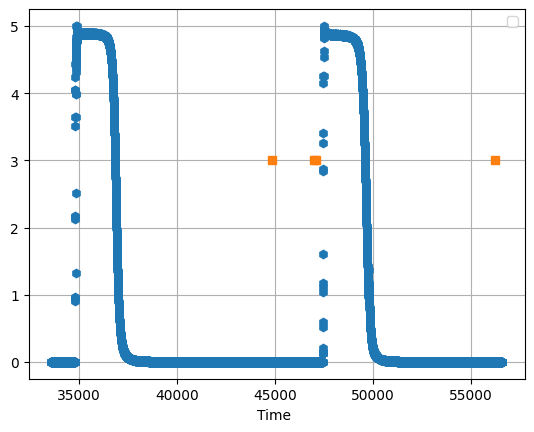

In [164]:


timeo=(datetime.datetime(2024,5,28,0,0,0)-TimeZero).total_seconds()
print("Start of the day, since timezero" ,timeo)
print("Start of file " ,DF["Time"].iloc[0])
print("Start of file ", DF["Time"].iloc[0]-timeo)


plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Meter"][::], fmt="h")

#plt.errorbar(x=(DF["Time"][::])-timeo , y=DF["Flow_Iter"][::], fmt="h")
#plt.errorbar(x=(DF["Time"][::60]-timeo)/3600.0  , y=DF["Target_Channel"][::60])


x=DF["Time"][np.where(np.abs(DF["Flow_Meter"].diff(1500)) < 0.0000005)[0]] -timeo 
y=3*np.ones(len(x))
plt.errorbar(x,y,marker="s",fmt=" ")

June5_dt = datetime.datetime(2024,6,6)

June5_secs = (June5_dt - TimeZero).total_seconds()


#plt.errorbar(x=np.array([June5_secs,June5_secs])/60,y=[0,5])
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June
# 06["Xe_Cell_Top"][::60], fmt="x", label="Top of drift cell")
#plt.errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Cryostat_Top"][::60], fmt="x", label="Top of cryo")
#plt
# .errorbar(DF_June06["Time"][::60]/60.0,DF_June06["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()

#plt.xlim(550,800)
#plt.ylim(4000,6000)
#plt.title("Thermocouple Data on June 6th")
plt.xlabel("Time ")

#plt.ylabel("Temperature [K]")
#plt.xlim(37500,49000)

# Data from 20240920

In [15]:
date=20240920
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    print(os.path.getsize(file))
    if os.path.getsize(file) <=280000:
        continue
    print(file)
    df = pd.DataFrame.from_dict(calib_dict_wtime(file))
    slowcontrol_dict_list.append(DF)
DF=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240920_slow_control.h5', 'A:/DATA\\20240920_slow_control_1.h5', 'A:/DATA\\20240920_slow_control_10.h5', 'A:/DATA\\20240920_slow_control_11.h5', 'A:/DATA\\20240920_slow_control_12.h5', 'A:/DATA\\20240920_slow_control_13.h5', 'A:/DATA\\20240920_slow_control_14.h5', 'A:/DATA\\20240920_slow_control_2.h5', 'A:/DATA\\20240920_slow_control_3.h5', 'A:/DATA\\20240920_slow_control_4.h5', 'A:/DATA\\20240920_slow_control_5.h5', 'A:/DATA\\20240920_slow_control_6.h5', 'A:/DATA\\20240920_slow_control_7.h5', 'A:/DATA\\20240920_slow_control_8.h5', 'A:/DATA\\20240920_slow_control_9.h5']
6559408
A:/DATA\20240920_slow_control.h5
{'year': 2024, 'mon': 9, 'day': 20, 'hour': 4, 'min': 40, 'sec': 16} 2024-09-20 04:40:16
Time offset 54276016.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3

In [293]:
def RTD_root_calibration(Vs,RTD_coef):
    Ts=[]
    for v in Vs:
        coef=[RTD_coef[0][3]/10,RTD_coef[0][2]/100,RTD_coef[0][1]/10,RTD_coef[0][0],v-100]
        if r <=0.0200039:
            Ts.append(np.roots(coef)[3].real+273.15)
            print()
        else:
            Ts.append(np.roots(coef[2:])[1].real+273.15)

    return Ts

In [31]:
DF=pd.DataFrame.from_dict(raw_dict_wtime("A:/DATA\\20240920_slow_control_13.h5"))
DF=add_hour(DF)


calib_DF=OMB_Calibration(DF)
calib_DF=TC_Calibration(calib_DF)
calib_DF=RTD_Calibration(calib_DF)


{'year': 2024, 'mon': 9, 'day': 20, 'hour': 9, 'min': 39, 'sec': 10} 2024-09-20 09:39:10
Time offset 54293950.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3', 'omb_daq/RTD_4', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/RTD constant', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Outside'])
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope
Pressure_Nitro
Pressure_Manifold
Flow_Meter
Pressure_Cr

In [29]:
calib_DF[1:5]

,Flow_Meter,omb_daq_Inter,Liquid_Nitro_Valve,PID_Heater,Pressure_Cryostat,Pressure_Manifold,Pressure_Nitro,RTD constant,RTD_1,RTD_2,...,Time,Valve_State,Cold_Finger,tc08_daq_Inter,Nitro_Reservoir,tc08_daq_Slope,Storage_1,Storage_2,Xe_Cell_Outside,hours
1,-0.001133,0.0,0.0,0.0,0.023975,-20.467262,-0.741749,5.775000e-04,208.607833,210.841385,...,54293952.0,0.0,212.418706,1.911,184.114942,0.995,295.042114,NaN,218.880315,9.653333
2,-0.001141,0.0,0.0,0.0,0.060360,-20.474074,-0.742030,4.183000e-07,208.607833,210.829405,...,54293954.0,0.0,212.445999,2.566,184.165602,0.993,295.042114,NaN,218.889152,9.653889
3,-0.001152,0.0,0.0,0.0,0.094343,-20.484582,-0.742467,-4.183000e-09,208.613819,210.841385,...,54293956.0,0.0,212.445999,2.594,184.211206,0.992,295.044556,NaN,218.897975,9.654444
4,-0.001163,-0.7,0.0,0.0,0.125764,-20.495091,-0.742886,-3.908300e-01,208.613819,210.829405,...,54293958.0,0.0,212.455313,2.346,184.267177,0.993,295.044708,NaN,218.898186,9.655000


In [61]:
#raw_DF=DF

def OMB_Calibration(raw_DF):
    ''' Takes the raw OMB DF and calibrations the flow metere and pressure sensors'''
    Keys=raw_DF.keys()
    if "omb_daq_Inter" not in Keys or "omb_daq_Slope" not in Keys:
        print("New calibration constants")

        return raw_DF
    calib_DF=raw_DF.copy()
    Inter=raw_DF["omb_daq_Inter"]
    Slope=raw_DF["omb_daq_Slope"] 
    for i,calib_key in omb_map:    
        print(calib_key)
        calib_DF[calib_key]=Inter[i]+Slope[i]*raw_DF[calib_key]
    return calib_DF

def TC_Calibration(raw_DF):
    ''' Takes the raw OMB DF and calibrations the flow metere and pressure sensors'''
    Keys=raw_DF.keys()
    if "tc08_daq_Inter" not in Keys or "tc08_daq_Slope" not in Keys:
        print("New calibration constants")
        return raw_DF
    Inter=raw_DF["tc08_daq_Inter"]
    Slope=raw_DF["tc08_daq_Slope"] 
    calib_DF=raw_DF.copy()
    for i,calib_key in tc08_map:    
        print(calib_key)
        calib_DF[calib_key]=Inter[i]+Slope[i]*raw_DF[calib_key]
    return calib_DF



def RTD_Calibration(raw_DF):
    ''' Calibrates the raw RTD volatge to Temp'''

    Keys=raw_DF.keys()
    if "RTD constant" not in Keys:
        print("New calibration constants")
        # return raw_DF
     
    RTD_const = np.array(raw_DF["RTD constant"][:16])
    RTD_const=RTD_const.reshape(4,4)
    calib_DF=raw_DF.copy()
    for key in ["RTD_1","RTD_2","RTD_3","RTD_4"]:
        calib_DF[key] = RTD_root_calibration(raw_DF[key]/0.0002,RTD_const)

    
    
    return calib_DF



    
    


Text(0.5, 0, 'Time of Day[H]')

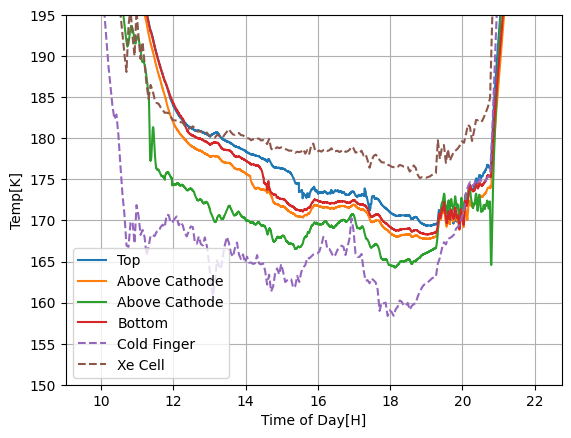

In [30]:

plt.errorbar(x=calib_DF["hours"],y=calib_DF["RTD_4"],label="Top")
plt.errorbar(x=calib_DF["hours"],y=calib_DF["RTD_3"],label="Above Cathode")
plt.errorbar(x=calib_DF["hours"],y=calib_DF["RTD_1"],label="Above Cathode")
plt.errorbar(x=calib_DF["hours"],y=calib_DF["RTD_2"],label="Bottom")


plt.errorbar(x=calib_DF["hours"][::100],y=calib_DF["Cold_Finger"][::100]-10, fmt="--",label="Cold Finger")
plt.errorbar(x=calib_DF["hours"][::100],y=calib_DF["Xe_Cell_Outside"][::100]-10, fmt="--",label="Xe Cell")



plt.legend()
plt.ylim(150,195)
plt.grid()
plt.ylabel("Temp[K]")
plt.xlabel("Time of Day[H]")

In [20]:
testfile=h5py.File("A:/DATA\\20240920_slow_control_13.h5")


nums =testfile["omb_daq/RTD constant"][0:4].flatten()
print(type(nums))
count=len(DF["RTD constant"])

newcol = np.array(np.pad(nums, (0,count-16)))
newcol.tolist()

DF["Test"]=newcol.tolist()

#print(type(newcol))

<class 'numpy.ndarray'>


In [106]:
def RTD_equ(T, r, A,B,C):
    R = 100   # The value of R
    # A = 3.9083*10**(-3)   # The value of A
    # B = -5.775*10**(-7) # The value of B
    # C = -4.183*10**(-12) # The value of C

    return R * (1+ A * T + B * T**2  -C * T**3 * (T- 100)) - r

def RTD_voltage_Calibration(voltage,A= 3.9083*10**(-3),B= -5.775*10**(-7),C= -4.183*10**(-12)):
    current=0.0002 #amps
    rs = voltage/current
    # Initial guess for T
    T_guess = 500
    # Solve for T
    Ts=[]
    for r in rs:
        #Need to change araound for values above and below 0C
        Ts.append(fsolve(RTD_equ, T_guess, args=(r, A,B,C))[0] + 273.15 ) #values below 0 C

    return Ts
    


In [2]:

def RTD_root_calibration(Vs,RTD_coef):
    Ts=[]
    for v in Vs:
        coef=[RTD_const[0][3]/10,RTD_const[0][2]/100,RTD_const[0][1]/10,RTD_const[0][0],v-100]
        if r <=0.0200039:
            Ts.append(np.roots(coef)[3].real+273.15)
        else:
            Ts.append(np.roots(coef[2:])[1].real+273.15)
    return Ts


In [95]:
vs=raw_DF["RTD_1"].iloc[10000:10004]

vs/current




10000    57.928562
10001    57.928562
10002    57.928562
10003    57.926178
Name: RTD_1, dtype: float64

In [32]:
RTD_const = np.array(raw_DF["RTD constant"][:16])
RTD_const=RTD_const.reshape(4,4)
RTD_const

array([[-3.9083e-01,  5.7750e-04,  4.1830e-07, -4.1830e-09],
       [-3.9083e-01,  5.7750e-04,  4.1830e-07, -4.1830e-09],
       [-3.9083e-01,  5.7750e-04,  4.1830e-07, -4.1830e-09],
       [-3.9083e-01,  5.7750e-04,  4.1830e-07, -4.1830e-09]])

In [35]:
raw_DF=DF

rs=raw_DF["RTD_4"]/0.0002
Ts_old=[]
Ts_new=[]
Ts_s=[]
for r in rs:


    # coef=[RTD_const[0][3]/10,RTD_const[0][2]/100,RTD_const[0][1]/10,RTD_const[0][0],r-100]
    coef=[RTD_const[0][3],RTD_const[0][2],RTD_const[0][1],RTD_const[0][0],r-100]
    coef2=[-100*C,1000*C,100*B,100*A,100-r]
    if r <=0.0200039:
        Ts_old.append(np.roots(coef)[3].real+273)
        Ts_new.append(np.roots(coef2)[3].real+273)
    else:
        Ts_old.append(np.roots(coef[2:])[1].real+273)
        Ts_new.append(np.roots(coef2[2:])[1].real+273)
    
    
    
#Ts_s = (RTD_voltage_Calibration(rs))



Text(0.5, 1.0, 'Calibrations')

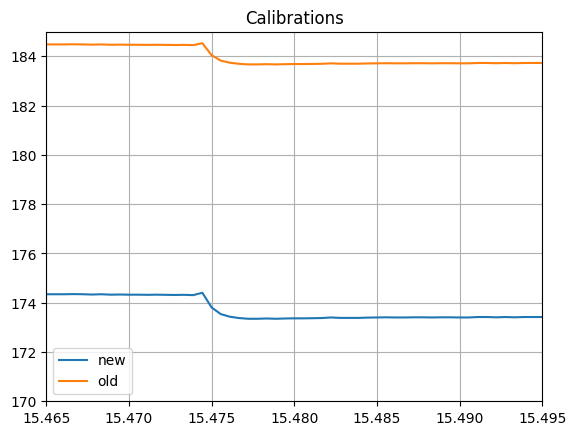

In [71]:

plt.errorbar(x=raw_DF["hours"], y=Ts_new,label="new")
plt.errorbar(x=raw_DF["hours"], y=Ts_old,label="old")
#plt.errorbar(x=raw_DF["hours"][::100], y=Ts_old[::100],fmt="--",label="new solve")
plt.grid(True)
plt.legend()
plt.ylim(170,185)
plt.xlim(15.465,15.495)
plt.title("Calibrations")

In [57]:
raw_DF=pd.DataFrame.from_dict(raw_dict_wtime("A:/DATA\\20240920_slow_control_13.h5"))



{'year': 2024, 'mon': 9, 'day': 20, 'hour': 9, 'min': 39, 'sec': 10} 2024-09-20 09:39:10
Time offset 54293950.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3', 'omb_daq/RTD_4', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/RTD constant', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Outside'])
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope
Not in channel list  Inter
Not in channel list  RTD constant
Not in channel list  Slope


In [78]:

DF=add_hour(raw_DF)

DF=OMB_Calibration(DF)
DF=TC_Calibration(DF)
DF= add_hour(DF)
DF=RTD_Calibration(DF)

Pressure_Nitro
Pressure_Manifold
Flow_Meter
Pressure_Cryostat
Cold_Finger
Xe_Cell_Outside
Nitro_Reservoir
Storage_1
Storage_2


In [79]:


DF.query("abs(hours - 15.475) <0.005 ")[["RTD_4","hours","Pressure_Cryostat"]]

,RTD_4,hours,Pressure_Cryostat
10471,174.476192,15.470000,25.057968
10472,174.476192,15.470556,25.057482
10473,174.470265,15.471111,25.054538
10474,174.476192,15.471667,25.054385
10475,174.470265,15.472222,25.052004
10476,174.464337,15.472778,25.051361
10477,174.470265,15.473333,25.050274
10478,174.458410,15.473889,25.051499
10479,174.553250,15.474444,25.051365
10480,173.960541,15.475000,25.050994


In [316]:
coef3=[]
for i in coef2:
    coef3.append("%s"%float(i))

print(coef)
print(coef3)




[-4.183e-09, 4.183e-07, 0.0005775, -0.39083, -3.3069610595703125]
['4.1829999999999994e-10', '-4.182999999999999e-09', '-5.7749999999999994e-05', '0.39083', '3.3069610595703125']


In [ ]:
-4.183e-09, 4.183e-07, 0.0005775, -0.39083, 
4.183e-10, -4.183e-09, -5.775e-05, 0.39083

# Look at LN2 use


In [43]:
date=20250204
data_loc=env_var_dataloc
search_term=data_loc+"/"+f"{date}*"
file_list =glob.glob(search_term)

print(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    print(os.path.getsize(file))
    if os.path.getsize(file) <=280000:
        continue
    print(file)
    df = pd.DataFrame.from_dict(calib_dict_wtime(file))
    slowcontrol_dict_list.append(DF)
DF=pd.concat(slowcontrol_dict_list)



\\172.24.54.234\NAS-Lab28\Data\SlowControl/20250204*
['\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control.h5', '\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control_1.h5', '\\\\172.24.54.234\\NAS-Lab28\\Data\\SlowControl\\20250204_slow_control_2.h5']
11147496
\\172.24.54.234\NAS-Lab28\Data\SlowControl\20250204_slow_control.h5
{'year': 2025, 'mon': 2, 'day': 4, 'hour': 1, 'min': 44, 'sec': 44}
{'year': 2025, 'mon': 2, 'day': 4, 'hour': 1, 'min': 44, 'sec': 44} 2025-02-04 14:44:04
Time offset 66149044.0
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/RTD constant', 'omb_daq/RTD_1', 'omb_daq/RTD_2', 'omb_daq/RTD_3', 'omb_daq/RTD_4', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_inf

In [38]:
DF

,Flow_Meter,omb_daq_Inter,Liquid_Nitro_Valve,PID_Heater,Pressure_Cryostat,Pressure_Manifold,Pressure_Nitro,RTD constant,RTD_1,RTD_2,...,Time,Valve_State,Cold_Finger,tc08_daq_Inter,Nitro_Reservoir,tc08_daq_Slope,Storage_1,Storage_2,Xe_Cell_Outside,hours
0,-0.002012,0.0,0.0,0.0,1.414811,0.028933,0.103257,-3.908300e-01,0.016158,0.016185,...,66125520.0,0.0,230.639343,2.630,219.785873,0.993,295.419434,295.116028,232.922150,8.200000
1,-0.001767,0.0,0.0,0.0,1.414872,0.028921,0.103281,5.775000e-05,0.016158,0.016184,...,66125522.0,0.0,230.630463,1.911,219.781204,0.995,295.424194,295.113434,232.926285,8.200556
2,-0.002013,0.0,0.0,0.0,1.414956,0.028917,0.103262,4.183000e-09,0.016158,0.016185,...,66125524.0,1.0,230.639130,2.566,219.772278,0.993,295.416840,295.110992,232.930618,8.201111
3,-0.001867,0.0,0.0,0.0,1.414967,0.028930,0.074316,-4.183000e-10,0.016160,0.016185,...,66125526.0,1.0,230.630676,2.594,188.754517,0.992,295.419434,295.108704,232.926483,8.201667
4,-0.001909,-0.7,0.0,0.0,1.415055,0.028943,0.070120,-3.908300e-01,0.016160,0.016185,...,66125528.0,1.0,230.630676,2.346,206.896576,0.993,295.421875,295.116028,232.930817,8.202222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22081,-0.001590,NaN,0.0,0.0,-0.002964,0.029071,0.095556,0.000000e+00,0.019925,0.018404,...,66169682.0,0.0,283.539459,NaN,247.234161,NaN,159.413315,294.645996,292.039459,20.467222
22082,-0.001831,NaN,0.0,0.0,-0.002861,0.029074,0.102747,0.000000e+00,0.019928,0.018406,...,66169684.0,0.0,283.561859,NaN,247.258728,NaN,159.423813,294.648438,292.065613,20.467778
22083,-0.001335,NaN,0.0,0.0,-0.002946,0.028572,0.101972,0.000000e+00,0.019929,0.018406,...,66169686.0,0.0,283.576782,NaN,247.283295,NaN,159.430801,294.645996,292.084290,20.468333
22084,-0.001737,NaN,0.0,0.0,-0.002793,0.027182,0.097099,0.000000e+00,0.019930,0.018408,...,66169688.0,0.0,283.599060,NaN,247.311768,NaN,159.434082,294.650726,292.106537,20.468889


In [75]:
LN2_use = DF["Nitro_Weigth"].diff(60)

LN2_use_sum = LN2_use.cumsum()

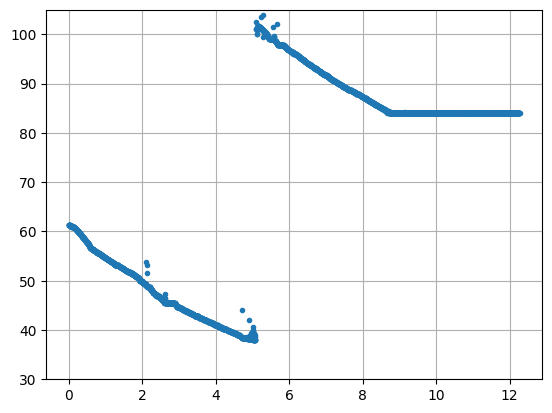

In [81]:
plt.errorbar(DF["hours"][::60]-DF["hours"].iloc[0],DF["Nitro_Weigth"][::60],fmt=".")


#plt.errorbar(DF["hours"][::1]-DF["hours"].iloc[0],LN2_use[::1])

#plt.yscale("log")
plt.ylim(30,105)
plt.grid(True)

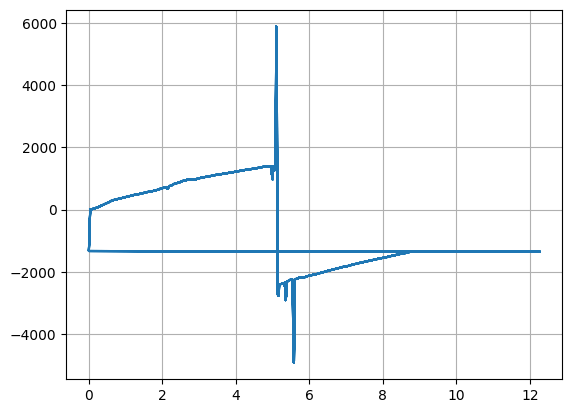

In [78]:
#plt.errorbar(DF["hours"][::60]-DF["hours"].iloc[0],DF["Nitro_Weigth"][::60],fmt=".")


plt.errorbar(DF["hours"][::1]-DF["hours"].iloc[0],-LN2_use_sum[::1])

#plt.yscale("log")
#plt.ylim(-5,2)
plt.grid(True)

<ErrorbarContainer object of 3 artists>

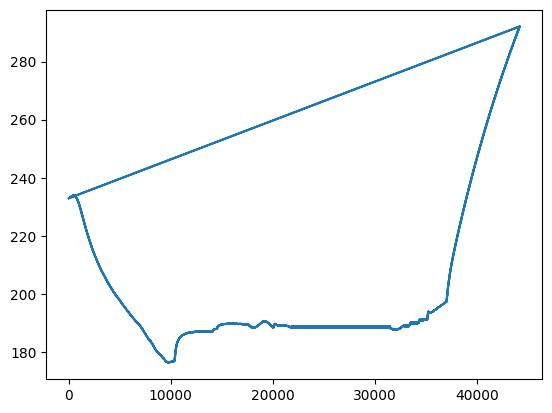

In [41]:
plt.errorbar(DF["Time"]-DF["Time"].iloc[0],DF["Xe_Cell_Outside"])